In [9]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# Plotting library
from matplotlib import pyplot
import matplotlib.pyplot as plt

# Optimization module in scipy
from scipy import optimize

# will be used to load MATLAB mat datafile format
from scipy.io import loadmat

# library written for this exercise providing additional functions for assignment submission, and others
import utils

# define the submission/grader object for this exercise
grader = utils.Grader()

# tells matplotlib to embed plots within the notebook
%matplotlib inline

import seaborn as sns

%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

### Introduction

Here I am writing what I have learned in great nitty gritty details about neural networks deep learning. The contents are mostly based on Andrew Ng's machine learning course on Coursera (https://www.coursera.org/learn/machine-learning). I strongly believe that you need to implement algorithms such as feedforward, back propagation, gradient descend, and cost function yourself in order to truly understand the inner working of a neural network. I hope through this writing I will deepen my understanding of this topic and others may be able to pick up one insight or two.

### Objective
Here, I use a small subset of MNIST data set as examples and aim to build a simply neural network to recognize those hand-written digits. To really understand how neural network works, we must understand what forward pass and back propagation are doing. I believe the most effective way to gain the intuition is to implement the key steps such as the cost function, feed forwrad, back propagation process. 

### neural network model representation

The neural network is shown in the following figure. Briefly, This simple neural network has 3 layers: input layer, hidden layer, and output layer
* Input layer l1 has 401 units (400 image pixels + 1 bias). Input X dimension is (5000, 401). Each row are pixel gray scale values for a training example. Each column are pixels for a specific square in the 20x20 grid for all training examples.

* Hidden layer l2 has 26 units (25 units derived from l1 + 1 bias). 
* Weight dimension for input layer is (25, 401). Each row are 401 weights for each input unit connecting to a specific unit in the hidden layer. Each column are weights for a specific input unit connecting to all units in hidden layer. 

* The output layer l3 has 10 units, with each unit representing the probability of being a hand-written number 0 to 9.

* Weights dimension for hidden layer is (10, 26). Each row are  26 weights for each of the 26 units in hidden layer transforming into a specific unit in output layer. Each column are weights for a specific unit in hidden layer transforming into 10 units in the output layer.


shapes of neural network variables:

|Items|dimension_x|dimension_y|
|------|------|------|
|a1|	5000|	401|
|theta1|	26|	401|
|a2|	5000|26
|theta2|	10|26|
|a3	|5000|10|
|J|	1||		
|d1|26||
|d2|10||
|theta1_grad|	25|401|
|theta2_grad|	10|	26|



cost is the summation of all costs: costs of each training example to all k labels, and costs of all training examples


![](Figures/neural_network.png)

### forward pass
The forward pass happens when we feed the input signal to the neural network and let it predict the 10 probabilities of the image being each of the 10 numbers. The input signal are values of 400 gray scale intensity of an hand-written image in this case. 

What really happens in forward pass is just some simple mathatical operations, namely matrix multiplication and activation. This a two-step process. First, we compute the weighted sum of all the units in previous layer for all the units in current layer.  Then we feed the sum into a activation function. In this case, we choose sigmoid function, which squashes the numbers into a value between 0 and 1. Ideally, we would be better off to use softmax function for the last layer so that the sum of all the probabilities is equal to 1. 

Let's get to the math behind.

The implementation of forward pass can be as simple as a few lines of code. In below code snippet,  X is input; a2 is activation in hidden layer; a3 is activation in final output layer.
    
    a1 = np.concatenate([np.ones((X.shape[0], 1)), X], axis=1) # add bias to input matrix
    a2 = sigmoid(a1 @ Theta1.T) # weight multiple input, and then apply activate function    
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1) # add bias to activation in hidden layer
    a3 = sigmoid(a2 @ Theta2.T) # weight multiple input, and then apply activate function

### back propagation
Back propagation is basically the opposite of forward pass. This process propagates the prediction error backward to each of the previous layers except the input layer so that we could compute the gradients for the weights and then finally update the weights in order to minimize the cost function.

#### calculate deltas (prediction errors)
We could think deltas as prediction errors. It is very straight forward to calculate the delta for the ouput layer (delta2). We have predicted probabilities and the true labels of all input images. Therefore, the error (delta2) is just simply the difference of these two vectors. Let's use one single training image as an example, in our case, predicted vector is the probabilities for each of the 10 numbers and the label is a one-hot encoded vector with 10 elements, which are all zeros except the elements corresponding to the label number. For instance, if the input image is 0, which is one-hot encoded as y, and the predictions is a vector (a3). Detla2 is a vector with shape (10,).

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
a3 = 
\begin{bmatrix} 0.92 \\ 0.01 \\ 0.02 \\ \vdots \\ 0 \end{bmatrix}, \quad 
delta2 = a3 - y =
\begin{bmatrix} -0.08 \\ 0.01 \\ 0.02 \\ \vdots \\ 0 \end{bmatrix}.
$$

delta2 can be computed as follow:

    # a3 is the prediction; y is the label
    delta2 = a3 - y # prediction error

Now we need to back propagate the error from output layer into the hidden layer.The error of hidden layer (delta1) is the product of 2 components. One is the weighed sum of delta2 backward to hidden layer, and the other is the gradient of each activation in hidden layer. 

    
    

##### component 1: weighted sum of delta2 (WSD)
For each unit in hidden layer, this can be calculated by computing the product of weights(W2) of the unit connecting to each of the 10 output units and the error in output layer (delta2). For example

$$
W2 = 
\begin{bmatrix} -0.82 \\ 0.12 \\ -0.20 \\ \vdots \\ 0 \end{bmatrix}, \quad
delta2 = 
\begin{bmatrix} -0.08 \\ 0.01 \\ 0.02 \\ \vdots \\ 0 \end{bmatrix}, \quad
weighted\_sum = 0.0628 
$$

Weighted sum of delta2 can be computed as follow:
    WSD = Theta2.T @ delta2 

##### component 2: sigmoid gradient of activation (SGA)
This is basically to compute the gradient of the activation for each unit in hidden layer. Let's use one training image to walk through the process. First, we compute the weighted sum by multiplying the input pixel values (400 + 1 bias) and their corresponding weights and summing them for each unit in hidden layer. Then we calculate the activation by applying sigmoid function to the weighted sums for each unit to squash them to values between 0 and 1. Lastly, We compute the derivative of the activation, which is just the product of activation and (1 - activation).

Sigmoid function is given by this formula:
$$
\sigma(z) = \frac{1}{1 + e^{-z}} = \frac{e^{z}}{e^{z} + 1}
$$

The gradient for the sigmoid function can be computed as following:
$$
\sigma'(z) = \frac{\partial \sigma}{\partial z} = \sigma(z)(1 - \sigma(z))
$$

This code snippet shows how this can be accomplished:

    # gradient for each activation in layer 2
    SGA = sigmoidGradient(np.hstack((1, X1 @ Theta1.T)))
    
Then put the two component together:

    delta1 = WSD * SGA


##### compute the weight gradients
To calculate the gradients, you basically just multiply the error in output layer (delta2) by the activations in its previous layer. To be more explicit, the error for the first unit in the output layer multiplying each of the 26 activations in the hidden layer gives the gradient for each weight corresponding to the first unit in the output layer. We repeat the calculations for errors of other remaining units.

Similarly, we could multiply the error in hidden layer (delta1) by the activations in its previous layer (they are just input pixel values in this case since the previous layer is input layer) to calculate the gradients for weights connecting input layer and hidden layer (Theta1).

We need to do this for all training examples (or a mini batch of training examples) and then calculate the average gradients, which we could use to update the Theta1 and Theta2 (weights).


### Intutition of back propagation
When a traning image forward passes the network and generates a prediction, the error between the prediction and real label can be calculated. In order for the network to learn and produce better prediction, the network needs to learn from this training process. Depending on how bad the prediction is, the network either has to dramatically adjust the weights or just fine tuning them. This is where the back propagation comes in play.

How do the prediction errors affect the weight adjustment?
Intuitively, the bigger the error, the deeper the adjustment needs to be made. Recall the weight adjustment (gradient) is the product of error and the gradient of the activation in the previous layer. So indeed the greater the error, the steeper adjustment we need to do for the weights.

How do the activation values affect the weight adjustment?
By looking at the sigmoid plot, We know that the gradient reaches a maximum of 0.25 when the activation is 0.5. The gradients gradually decline when the activation is moving away from 0.5 in both directions. So this is equivalent to say that we adjust the weights associated with an activation of 0.5 more when others being equal. This makes sense to me because 0.5 basically means that we are absolutely no idea if this unit is supposed to be activated or not. In the final output layer, 0.5 means the network thinks there is 50% chance the input image is belong to that class. Therefore, the network will make relative large adjust to weights associated with this node. On the other hand, if the activation is close to 1 or 0, it is very confident about the activation or prediction, the weights associated with this node only need to be fine tuned.

How do the weights affect the adjustment of themselves?
The gradient for a weight is the product of the error (delta) and the weight itself. So we do bigger adjustment for large weights if others being equal.   

With these intuitions, It is easier to understand that neural network is capable of learning very complex patterns and mapping input to output with universal approximation. 

If you notice that I misunderstand something here, Please point out and constructively criticize. I appreciate your feedback.




### some variables 

k: the number of labels/classes, in this case k=10, representing numbers between 0 and 9

m: the number of training examples, in this case m=5000
Theta1: weights for input layer
Theta2: weights for hidden layer


## nnCostFunction implementation notes:

### 1) One-hot encoding of y:
y_encode is also a 5000x10 matrix, each row is a encoded label for a training iage. If the label is 2, the 3rd element in the row is 1 and the rest 9 elements are all 0s.
$$ y = \begin{bmatrix} 0 & 0 & 1 & 0 \cdots & 0 \end{bmatrix}$$

### 2) feedforwad outputs (activation of layer 3: a3): 
a3 is a 5000x10 matrix. Each row is a prediction for a training image. It shows the probability of being each number, 0 to 9. For instance, following y_hat means the predicted digit is 2 with 90% chance and is 0 with 10% probability.
$$ y_{hat} = \begin{bmatrix} 0.1 & 0 & 0.9 & 0 & \cdots & 0 \end{bmatrix}$$


### 3) calculate the cost (loss),
The cost function without regularization is:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

The cost function for neural networks with regularization is given by:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$
use the cost function formula? cost for every class and cost for every training image

4) the dimensions do not look right, why does it still work?

5) * is element_wise operation, not matrix multiplication @

6) for the cost, we only need element-wise multiplication, what is the ituition. when we predicted the exact label at 100% confidence, the cost is 0. when we predict wrong label with 100% confidence, the cost is infinity.  

Sigmoid function squashes input (a number) into a value, which is between 0 and 1. We use sigmoid function as activation function because we would like to constrain the activation. When it is close to 1, we are saying the unit is activated. When is close to 0, we are saying the unit is not activated.

Sigmoid function is given by this formula:
$$
\sigma(z) = \frac{1}{1 + e^{-z}} = \frac{e^{z}}{e^{z} + 1}
$$

The gradient for the sigmoid function can be computed as following:
$$
\sigma'(z) = \frac{\partial \sigma}{\partial z} = \sigma(z)(1 - \sigma(z))
$$

The intuition is that the gradient of a sigmoid function is equal to the sigmoid function times 1 minus the sigmoid function iteself().



Now complete the implementation of `sigmoidGradient` in the next cell.


In [51]:
# neural network structure
input_size  = 400  # 20x20 Input Images of Digits
hidden_size = 25   # 25 hidden units
num_labels = 10    # 10 labels, from 0 to 9

In [52]:
# training images
data = np.loadtxt('MNIST_data.csv')
X = data[:, :-1]
y= data[:,-1]
X.shape
y.shape

(5000, 400)

(5000,)

In [53]:
# each label needs to one-hot encoded into a vector with a shape of (10,)
def one_hot(x):
    y = np.zeros((x.shape[0], num_labels))
    for i, j in enumerate(x.astype(int)):
        y[i, j] = 1
    return y

### one-hot encode image labels (y)

In [54]:
y_encode = one_hot(y)
y[:2]

array([0., 0.])

In [55]:
y_encode

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [56]:
# load weights previously learned
nn_params = np.loadtxt('weights.csv')
nn_params.shape
nn_params[:2]

(10285,)

array([-2.25623899e-02, -1.05624163e-08])

In [57]:
# Reshape nn_params back into the parameters Theta1 and Theta2
Theta1 = nn_params[:((input_size+1) * hidden_size)].reshape(hidden_size,input_size+1)
Theta2 = nn_params[((input_size +1)* hidden_size ):].reshape(num_labels,hidden_size+1)
Theta1.shape
Theta2.shape

(25, 401)

(10, 26)

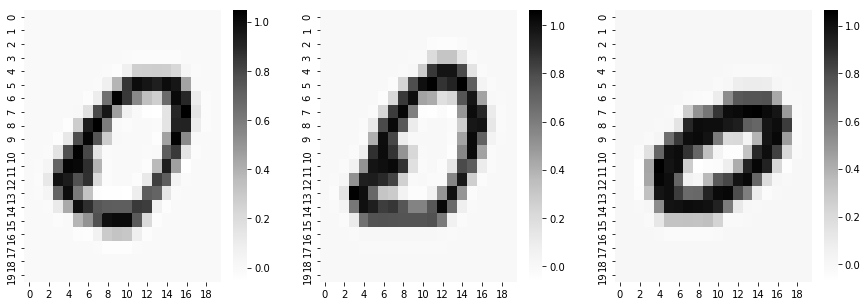

In [13]:
# look at some examples
fig = plt.figure(figsize=(15, 5))
axes = fig.subplots(1,3)
for i in range(3):
    _ = sns.heatmap(X[i,:].reshape(20,20), cmap='Greys', ax=axes[i])



<a id="section1"></a>
### 1.3 Feedforward and cost function

Now you will implement the cost function and gradient for the neural network. First, complete the code for the function `nnCostFunction` in the next cell to return the cost.

Recall that the cost function for the neural network (without regularization) is:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

where $h_\theta \left( x^{(i)} \right)$ is computed as shown in the neural network figure above, and K = 10 is the total number of possible labels. Note that $h_\theta(x^{(i)})_k = a_k^{(3)}$ is the activation (output
value) of the $k^{th}$ output unit. Also, recall that whereas the original labels (in the variable y) were 0, 1, ..., 9, for the purpose of training a neural network, we need to encode the labels as vectors containing only values 0 or 1, so that

$$ y = 
\begin{bmatrix} 1 \\ 0 \\ 0 \\\vdots \\ 0 \end{bmatrix}, \quad
\begin{bmatrix} 0 \\ 1 \\ 0 \\ \vdots \\ 0 \end{bmatrix}, \quad \cdots  \quad \text{or} \qquad
\begin{bmatrix} 0 \\ 0 \\ 0 \\ \vdots \\ 1 \end{bmatrix}.
$$

For example, if $x^{(i)}$ is an image of the digit 5, then the corresponding $y^{(i)}$ (that you should use with the cost function) should be a 10-dimensional vector with $y_5 = 1$, and the other elements equal to 0.

You should implement the feedforward computation that computes $h_\theta(x^{(i)})$ for every example $i$ and sum the cost over all examples. **Your code should also work for a dataset of any size, with any number of labels** (you can assume that there are always at least $K \ge 3$ labels).

<div class="alert alert-box alert-warning">
**Implementation Note:** The matrix $X$ contains the examples in rows (i.e., X[i,:] is the i-th training example $x^{(i)}$, expressed as a $n \times 1$ vector.) When you complete the code in `nnCostFunction`, you will need to add the column of 1’s to the X matrix. The parameters for each unit in the neural network is represented in Theta1 and Theta2 as one row. Specifically, the first row of Theta1 corresponds to the first hidden unit in the second layer. You can use a for-loop over the examples to compute the cost.
</div>
<a id="nnCostFunction"></a>


## nnCostFunction implementation notes:

### 1) One-hot encoding of y:
y_encode is also a 5000x10 matrix, each row is a encoded label for a training iage. If the label is 2, the 3rd element in the row is 1 and the rest 9 elements are all 0s.
$$ y = \begin{bmatrix} 0 & 0 & 1 & 0 \cdots & 0 \end{bmatrix}$$

### 2) feedforwad outputs (activation of layer 3: a3): 
a3 is a 5000x10 matrix. Each row is a prediction for a training image. It shows the probability of being each number, 0 to 9. For instance, following y_hat means the predicted digit is 2 with 90% chance and is 0 with 10% probability.
$$ y_{hat} = \begin{bmatrix} 0.1 & 0 & 0.9 & 0 & \cdots & 0 \end{bmatrix}$$


### 3) calculate the cost (loss),
The cost function without regularization is:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right]$$

The cost function for neural networks with regularization is given by:
$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m}\sum_{k=1}^{K} \left[ - y_k^{(i)} \log \left( \left( h_\theta \left( x^{(i)} \right) \right)_k \right) - \left( 1 - y_k^{(i)} \right) \log \left( 1 - \left( h_\theta \left( x^{(i)} \right) \right)_k \right) \right] + \frac{\lambda}{2 m} \left[ \sum_{j=1}^{25} \sum_{k=1}^{400} \left( \Theta_{j,k}^{(1)} \right)^2 + \sum_{j=1}^{10} \sum_{k=1}^{25} \left( \Theta_{j,k}^{(2)} \right)^2 \right] $$
use the cost function formula? cost for every class and cost for every training image

4) the dimensions do not look right, why does it still work?

5) * is element_wise operation, not matrix multiplication @

6) for the cost, we only need element-wise multiplication, what is the ituition. when we predicted the exact label at 100% confidence, the cost is 0. when we predict wrong label with 100% confidence, the cost is infinity.  

## modify the implementation myself

In [58]:
def sigmoid(z):
    return 1/(1 + np.exp(-z))

In [59]:
# this is simply applying sigmoid function to each element of matrix, and then for each element, times itself with (1-the element)
def sigmoidGradient(z):
    sig = sigmoid(z)    
    return sig * (1-sig)

### sigmoidGradient peaks when activation is 0.5

g is [1.92874985e-22 2.13181162e-22 2.35625206e-22 2.60432193e-22
 2.87850898e-22 3.18156288e-22 3.51652275e-22 3.88674772e-22
 4.29595055e-22 4.74823489e-22 5.24813642e-22 5.80066837e-22
 6.41137173e-22 7.08637090e-22 7.83243502e-22 8.65704593e-22
 9.56847315e-22 1.05758568e-21 1.16892995e-21 1.29199670e-21
 1.42802012e-21 1.57836430e-21 1.74453694e-21 1.92820449e-21
 2.13120885e-21 2.35558583e-21 2.60358556e-21 2.87769508e-21
 3.18066329e-21 3.51552845e-21 3.88564874e-21 4.29473587e-21
 4.74689232e-21 5.24665251e-21 5.79902823e-21 6.40955891e-21
 7.08436722e-21 7.83022039e-21 8.65459814e-21 9.56576766e-21
 1.05728665e-20 1.16859943e-20 1.29163139e-20 1.42761635e-20
 1.57791801e-20 1.74404367e-20 1.92765929e-20 2.13060625e-20
 2.35491978e-20 2.60284939e-20 2.87688141e-20 3.17976395e-20
 3.51453443e-20 3.88455007e-20 4.29352153e-20 4.74555014e-20
 5.24516902e-20 5.79738855e-20 6.40774661e-20 7.08236411e-20
 7.82800639e-20 8.65215105e-20 9.56306293e-20 1.05698770e-19
 1.16826901e-19 1.2

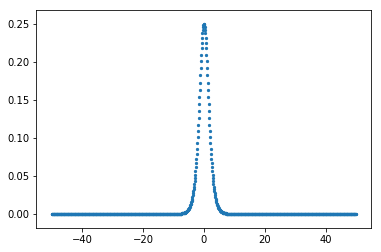

In [124]:
# to compute sigmoidGradient, squash the number to sig first,
# and then calculate sig * (1 - sig)
# the greater the activation, the higher the gradient
a = np.linspace(-50,50,1000)
plt.scatter(a, sigmoidGradient(a), s=5)
plt.savefig('sigmoidGradient@2x.png', dpi=300)

In [61]:
def forward_pass(Theta1, Theta2, X, y):   
#     m = X.shape[0]
    # feedforward to produce the prediction output
    # a1(X):input layer, a2 hidden layer activation, a3 output layer
    bias1 = np.ones((X.shape[0], 1))
    a1 = np.concatenate([bias1, X], axis=1) 
    a2 = sigmoid(a1 @ Theta1.T)
    
    bias2 = np.ones((a2.shape[0], 1))
    a2 = np.concatenate([bias2, a2], axis=1)
    a3 = sigmoid(a2 @ Theta2.T) # output layer
 
    return (a1, a2, a3)

In [122]:
def compute_costs_loop(Theta1, Theta2, num_labels, X, y, lambda_):     
    m = X.shape[0]
    J = 0
    a1, a2, a3 = forward_pass(Theta1, Theta2, X, y)
    # compute cost for each output unit (class)
    for j in range(num_labels):
        Jj = sum(-y[:,j] * np.log(a3[:,j]) - (1-y[:,j])*np.log(1-a3[:,j]))
        print(y[:,j].shape)
        J += Jj 
        print(f'compute cost for {j}', Jj)
    
    J = 1/m * J
    reg_J = J + lambda_/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    return (J, reg_J)

In [109]:
def compute_costs_vectorized(Theta1, Theta2, num_labels, X, y, lambda_):     
    m = X.shape[0]
    J = 0
    a1, a2, a3 = forward_pass(Theta1, Theta2, X, y)
    # below is vectorized J implementation
    J = np.sum(-y * np.log(a3) - (1 - y) * np.log(1 - (a3)))
  
    J = 1/m * J
    reg_J = J + lambda_/(2*m) * (np.sum(Theta1[:,1:]**2) + np.sum(Theta2[:,1:]**2))
    return (J, reg_J)

In [94]:
J, reg_J = compute_costs_vectorized(Theta1, Theta2, num_labels, X, y_encode, lambda_=0.0)
J
reg_J

0.2876291651613189

0.2876291651613189

In [123]:
compute_costs_loop(Theta1, Theta2, num_labels, X, y_encode, lambda_=0.0)

(5000,)
compute cost for 0 71.85847553673608
(5000,)
compute cost for 1 105.77238482303046
(5000,)
compute cost for 2 151.13409896391363
(5000,)
compute cost for 3 197.31569852900847
(5000,)
compute cost for 4 148.61622965727082
(5000,)
compute cost for 5 149.92213260735022
(5000,)
compute cost for 6 101.33146796645212
(5000,)
compute cost for 7 141.14000796503075
(5000,)
compute cost for 8 173.73617842845815
(5000,)
compute cost for 9 197.31915132934316


(0.28762916516131876, 0.28762916516131876)

In [72]:
compute_costs_vectorized(Theta1, Theta2, num_labels, X, y_encode, lambda_=0.0)

(1438.1458258065945, 0.2876291651613189)

In [110]:
def compute_gradient(Theta1, Theta2, num_labels,X, y,lambda_): 
    m = X.shape[0] 
    Theta1_grad = np.zeros((Theta1.shape))
    Theta2_grad = np.zeros((Theta2.shape))
    a1, a2, a3 = forward_pass(Theta1, Theta2, X, y)
#     for i in range(m):
    for i in range(1):
        a1i = a1[i,:] # 1 X 401
        a2i = a2[i,:] # 1 X 26
        a3i = a3[i,:] # 1 x 10
        delta2 = a3i - y[i,:]

        # Theta2.T @ d2.T is the 10 errors at layer 3 back propagated to layer 2
        # sigmoidGradient(np.hstack((1,a1i @ Theta1.T))) is the gradient for each activation in layer 2
        delta1 = Theta2.T @ delta2 * sigmoidGradient(np.hstack((1,a1i @ Theta1.T)))
        
        Theta1_grad= Theta1_grad + delta1[1:][:,np.newaxis] @ a1i[:,np.newaxis].T
        Theta2_grad = Theta2_grad + delta2.T[:,np.newaxis] @ a2i[:,np.newaxis].T
        
    Theta1_grad = 1/m * Theta1_grad
    Theta2_grad = 1/m*Theta2_grad
    
    Theta1_grad_reg = Theta1_grad + (lambda_/m) * np.hstack((np.zeros((Theta1.shape[0],1)),Theta1[:,1:]))
    Theta2_grad_reg = Theta2_grad + (lambda_/m) * np.hstack((np.zeros((Theta2.shape[0],1)),Theta2[:,1:]))
    grad = np.concatenate([Theta1_grad_reg.ravel(), Theta2_grad_reg.ravel()])

    return grad

In [111]:
compute_gradient(Theta1, Theta2, num_labels,X, y_encode,lambda_=0.0)

g is [0.19661193 0.04782555 0.07309204 0.00694906 0.24964942 0.20787312
 0.00349239 0.01062254 0.0016299  0.00348869 0.01998466 0.06663376
 0.02119201 0.04405998 0.04775892 0.00420003 0.10022623 0.00793126
 0.08754214 0.12899417 0.16136511 0.02325683 0.01589205 0.02672678
 0.05337726 0.09571899]


array([-5.12078395e-08,  0.00000000e+00,  0.00000000e+00, ...,
        1.26052392e-06,  1.22281085e-06,  1.38964573e-07])

In [599]:

# error is the 10 error values for each unit in layer 3
error = np.array([-4.26598801e-03,1.12661530e-04,1.74127856e-03,2.52696959e-03
                   ,1.84032321e-05,9.36263860e-03,3.99270267e-03,5.51517524e-03
                   ,4.01468105e-04,6.48072305e-03])
# wts is the 10 weights connecting the first unit in layer 2 to the 10 output units
wts = np.array([-0.46089119,-0.76100352,-0.61785176,-0.68934072,-0.67832479,-0.59664339
                ,-0.87794907,-0.52746527,-0.7490154,-0.6665468,])
# error*wts is the error for first unit in layer2, which is basically a weighted sum of error passed from layer 3 
np.sum(error*wts)

# component 2:sigmoidGradient(np.hstack((1,a1i @ Theta1.T)))
# this is basically the forward pass value z= singal @ weight befor applying sigmoid to get the acitvation value
# for each unit in layer 2, use 400 pixel values time their correspoding weights to each unit, then apply sigmoid, use the sigmoid activation to times (1-sigmoid) to get the gradient for each unit.
# then use this activation gradient to time the errors for each unit, which is the weighted sum of errors form layer3


# compute the theta2_gradient
# basically use the error times the activation. the error for the first unit in the output layer times each of th 26 activations to get the gradient for each weight corresponding to the first unit in the layer 3.
# similarly idea for theta1 gradient, use delta1 times each activation in the input layer to get gradients.
# we need to do this for all training examples. then calculate the average, use this to update the Theta1 and Theta2 (weights)


-0.01757087838907182